In [ ]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception

2025-10-05 05:56:14.415646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759643774.799887      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759643774.907751      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
if os.path.exists("food-101"):
    shutil.rmtree("food-101")
if os.path.exists("food-101-subset"):
    shutil.rmtree("food-101-subset")
if not os.path.exists("food-101.tar.gz"):
    !wget -c http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar -xzf food-101.tar.gz food-101/images

data_dir   = "food-101/images"
subset_dir = "food-101-subset"
os.makedirs(subset_dir, exist_ok=True)

# =======================
# 3) Select 20 classes + copy images
# =======================
selected_classes = [
    'guacamole', 'hot_and_sour_soup', 'ravioli', 'caprese_salad', 'chocolate_mousse',
    'strawberry_shortcake', 'oysters', 'sashimi', 'poutine', 'deviled_eggs',
    'huevos_rancheros', 'prime_rib', 'panna_cotta', 'tacos', 'beef_carpaccio',
    'donuts', 'waffles', 'bread_pudding', 'beignets', 'mussels'
]

for cls in selected_classes:
    src_folder = os.path.join(data_dir, cls)
    dst_folder = os.path.join(subset_dir, cls)
    os.makedirs(dst_folder, exist_ok=True)
    imgs = os.listdir(src_folder)
    for img in imgs:
        shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

print("✅ Copied all images for", len(selected_classes), "classes")

--2025-10-05 05:56:36--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2025-10-05 05:56:36--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  26.8MB/s    in 3m 13s  

2025-10-05 05:59:49 (24.7 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

✅ Copied all images for 20 classes


In [ ]:
# === create_splits.py ===
import os, shutil, random
from glob import glob
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)

SRC = 'food-101-subset'   # your 20-class folder
BASE = 'food20_split'     # new folder with train/val/test subfolders
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

if os.path.exists(BASE):
    shutil.rmtree(BASE)
os.makedirs(BASE, exist_ok=True)

for cls in sorted(os.listdir(SRC)):
    src_cls = os.path.join(SRC, cls)
    if not os.path.isdir(src_cls):
        continue
    imgs = [os.path.join(src_cls, f) for f in os.listdir(src_cls) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    train_val, test = train_test_split(imgs, test_size=TEST_RATIO, random_state=SEED, stratify=None)
    # split train_val into train and val by proportion
    val_size = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
    train, val = train_test_split(train_val, test_size=val_size, random_state=SEED, stratify=None)
    for split_name, files in [('train', train), ('val', val), ('test', test)]:
        out_dir = os.path.join(BASE, split_name, cls)
        os.makedirs(out_dir, exist_ok=True)
        for p in files:
            shutil.copy(p, out_dir)

print("✅ Created split folders under", BASE)

✅ Created split folders under food20_split


In [ ]:
# === data_and_generators.py ===
import numpy as np, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

SEED = 42
IMG_SIZE_TL   = 299   # for Xception transfer learning
BATCH_SIZE = 32
DATA_BASE = 'food20_split'   # created above



train_datagen_tl = ImageDataGenerator(
    preprocessing_function=xception_preprocess,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.12,
    zoom_range=0.2,
    brightness_range=(0.75,1.25),
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation / Test gens (no augmentation)
val_datagen_tl   = ImageDataGenerator(preprocessing_function=xception_preprocess)


# Generators - Transfer Learning (Xception, 299)
train_gen_tl = train_datagen_tl.flow_from_directory(
    os.path.join(DATA_BASE, 'train'),
    target_size=(IMG_SIZE_TL, IMG_SIZE_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)
val_gen_tl = val_datagen_tl.flow_from_directory(
    os.path.join(DATA_BASE, 'val'),
    target_size=(IMG_SIZE_TL, IMG_SIZE_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)
test_gen_tl = val_datagen_tl.flow_from_directory(
    os.path.join(DATA_BASE, 'test'),
    target_size=(IMG_SIZE_TL, IMG_SIZE_TL),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

CLASS_NAMES = list(train_gen_cust.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", NUM_CLASSES)


Found 16000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Found 16000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.
Classes: 20


In [ ]:
# === model_transfer_xception.py ===
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models

def build_xception_tl(input_shape=(299,299,3), num_classes=20):
    base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base.input, outputs=out)
    return model, base

model_tl, base_model = build_xception_tl((IMG_SIZE_TL, IMG_SIZE_TL, 3), NUM_CLASSES)
# Stage 1: freeze base
for layer in base_model.layers:
    layer.trainable = False

model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                 loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                 metrics=['accuracy'])
model_tl.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 22,050,108 (84.11 MB)

 Trainable params: 1,187,092 (4.53 MB)

 Non-trainable params: 20,863,016 (79.59 MB)

In [ ]:
# === train_both.py ===
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)


# Train TL - stage 1
ckp_tl = ModelCheckpoint('tl_stage1_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
history_tl_stage1 = model_tl.fit(
    train_gen_tl,
    epochs=6,
    validation_data=val_gen_tl,
    callbacks=[es, rlr, ckp_tl],
    verbose=1
)

# Stage 2: unfreeze last ~100 layers and fine-tune
unfreeze_from = max(0, len(base_model.layers) - 100)
for i, layer in enumerate(base_model.layers):
    layer.trainable = True if i >= unfreeze_from else False

# (recompile with lower lr)
model_tl.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                 loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
                 metrics=['accuracy'])

ckp_tl2 = ModelCheckpoint('tl_finetuned_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
history_tl_stage2 = model_tl.fit(
    train_gen_tl,
    epochs=30,
    validation_data=val_gen_tl,
    callbacks=[es, rlr, ckp_tl2],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1759644059.921935     133 service.cc:148] XLA service 0x7d99f041e5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759644059.925288     133 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759644059.925313     133 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759644060.925766     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/500 ━━━━━━━━━━━━━━━━━━━━ 3:41:29 27s/step - accuracy: 0.0625 - loss: 3.6267

I0000 00:00:1759644077.882394     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.1315 - loss: 3.0398
Epoch 1: val_loss improved from inf to 3.42218, saving model to cust_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 255s 458ms/step - accuracy: 0.1316 - loss: 3.0395 - val_accuracy: 0.0800 - val_loss: 3.4222 - learning_rate: 1.0000e-04
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.2139 - loss: 2.6700
Epoch 2: val_loss improved from 3.42218 to 2.95930, saving model to cust_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 227s 453ms/step - accuracy: 0.2139 - loss: 2.6699 - val_accuracy: 0.1990 - val_loss: 2.9593 - learning_rate: 1.0000e-04
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.2637 - loss: 2.4752
Epoch 3: val_loss improved from 2.95930 to 2.85403, saving model to cust_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 229s 458ms/step - accuracy: 0.2637 - loss: 2.4752 - val_accuracy: 0.2080 - val_loss: 2.8540 - learning_rate: 1.0000e-04
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accur

2025-10-05 06:51:08.147817: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-10-05 06:51:08.439513: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.291820076s
Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.2920 - loss: 2.8292
Epoch 1: val_loss improved from inf to 1.17314, saving model to tl_stage1_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 484s 912ms/step - accuracy: 0.2922 - loss: 2.8280 - val_accuracy: 0.7200 - val_loss: 1.1731 - learning_rate: 1.0000e-04
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.6017 - loss: 1.6085
Epoch 2: val_loss improved from 1.17314 to 1.07912, saving model to tl_stage1_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 444s 888ms/step - accuracy: 0.6017 - loss: 1.6084 - val_accuracy: 0.7610 - val_loss: 1.0791 - learning_rate: 1.0000e-04
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.6399 - loss: 1.4527
Epoch 3: val_loss improved from 1.07912 to 1.03257, saving model to tl_stage1_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 440s 880ms/step - accuracy: 0.6400 - loss: 1.4526 - val_accuracy: 0.7795 - val_loss: 1.0326 - learning_rate: 1.0000e-04
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/

E0000 00:00:1759649784.175789     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759649784.330231     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759649785.751155     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759649785.891483     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1759649786.450357     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - accuracy: 0.6036 - loss: 1.5745
Epoch 1: val_loss improved from inf to 0.98578, saving model to tl_finetuned_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 543s 989ms/step - accuracy: 0.6037 - loss: 1.5743 - val_accuracy: 0.7930 - val_loss: 0.9858 - learning_rate: 1.0000e-05
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.7005 - loss: 1.2713
Epoch 2: val_loss improved from 0.98578 to 0.91611, saving model to tl_finetuned_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 484s 966ms/step - accuracy: 0.7005 - loss: 1.2713 - val_accuracy: 0.8200 - val_loss: 0.9161 - learning_rate: 1.0000e-05
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.7366 - loss: 1.1405
Epoch 3: val_loss improved from 0.91611 to 0.87654, saving model to tl_finetuned_best.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 485s 969ms/step - accuracy: 0.7366 - loss: 1.1405 - val_accuracy: 0.8315 - val_loss: 0.8765 - learning_rate: 1.0000e-05
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━

In [ ]:
# === eval.py ===
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

def evaluate_model_keras(model, test_gen):
    # Predict all test images
    preds = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes  # works because shuffle=False and generator was created similarly
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    print("Accuracy:", acc)
    print("Precision (macro):", p)
    print("Recall (macro):", r)
    print("F1 (macro):", f1)
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))
    # Confusion matrix (optional)
    cm = confusion_matrix(y_true, y_pred)
    return {'accuracy':acc, 'precision':p, 'recall':r, 'f1':f1, 'cm':cm}

# Evaluate custom CNN
model_cust.load_weights('cust_best.h5')
res_cust = evaluate_model_keras(model_cust, test_gen_cust)

# Evaluate TL model
model_tl.load_weights('tl_finetuned_best.h5')
res_tl = evaluate_model_keras(model_tl, test_gen_tl)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step
Accuracy: 0.2275
Precision (macro): 0.3282057031919575
Recall (macro): 0.22749999999999998
F1 (macro): 0.16970640261236944

Classification report:

                      precision    recall  f1-score   support

      beef_carpaccio       0.38      0.29      0.33       100
            beignets       0.14      0.93      0.25       100
       bread_pudding       0.00      0.00      0.00       100
       caprese_salad       0.75      0.03      0.06       100
    chocolate_mousse       0.17      0.06      0.09       100
        deviled_eggs       0.00      0.00      0.00       100
              donuts       0.44      0.04      0.07       100
           guacamole       0.42      0.52      0.47       100
   hot_and_sour_soup       0.62      0.13      0.21       100
    huevos_rancheros       0.25      0.01      0.02       100
             mussels       0.49      0.32      0.39       100
             oysters       0.00      0.00      0.00       100
     

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 331ms/step
Accuracy: 0.9025
Precision (macro): 0.9042837892415843
Recall (macro): 0.9025000000000001
F1 (macro): 0.9029151028282699

Classification report:

                      precision    recall  f1-score   support

      beef_carpaccio       0.91      0.86      0.89       100
            beignets       0.94      0.92      0.93       100
       bread_pudding       0.77      0.86      0.82       100
       caprese_salad       0.90      0.92      0.91       100
    chocolate_mousse       0.88      0.80      0.84       100
        deviled_eggs       0.97      0.91      0.94       100
              donuts       0.88      0.93      0.90       100
           guacamole       0.93      0.93      0.93       100
   hot_and_sour_soup       0.99      0.99      0.99       100
    huevos_rancheros       0.85      0.87      0.86       100
             mussels       0.96      0.96      0.96       100
             oysters       0.99      0.92      0.95       100
     

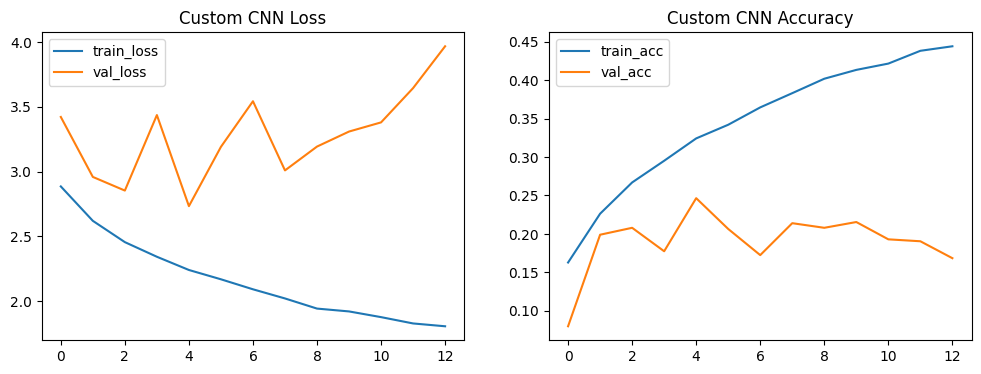

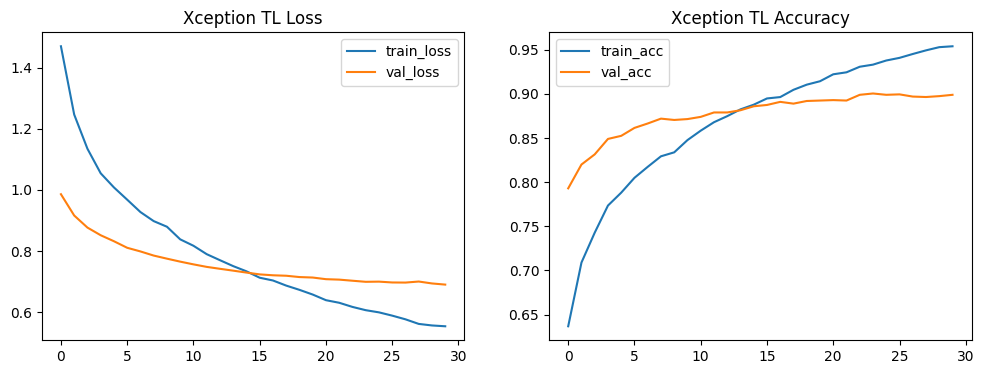

In [ ]:
# plot history example
import matplotlib.pyplot as plt

def plot_history(hist, title='Model'):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.legend(); plt.title(title + ' Loss')
    plt.subplot(1,2,2)
    plt.plot(hist.history.get('accuracy', hist.history.get('acc')), label='train_acc')
    plt.plot(hist.history.get('val_accuracy', hist.history.get('val_acc')), label='val_acc')
    plt.legend(); plt.title(title + ' Accuracy')
    plt.show()

plot_history(history_cust, 'Custom CNN')
plot_history(history_tl_stage2, 'Xception TL')